# Population, wealth, and energy consumption

In this notebook we load data, interpolate onto a uniform time array, and then save arrays for later use. This notebook does some heavy lifting for you in terms of creating the arrays that you will need for your analysis. Look closely at how the data are loaded, so that you can adapt to load difficult files yourself later.

Start by loading modules that we will need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## UN population projection

We start by loading a United Nations population projection (Medium-fertility variant, 2019). It is a well-behaved csv file with first line headers. If we use the np.genfromtxt() function then we can automatically assign names to columns using the headers. The time array is evenly spaced from 1950 to 2100, so ideal for our purposes. We rescale population values from numbers in thousands to millions, for later convenience.

In [2]:
dataDir = '../DATA/world-population/'
filename = dataDir + 'UN2019-population-projection-world-Medium.csv'

unPopulationModel = np.genfromtxt(filename, delimiter=',', names=True)

t = unPopulationModel['Time']

N = unPopulationModel['PopTotal'] / 1000

## World Bank economic data

The gdp per capita data from the World Bank are in US dollars inflation-adjusted to 2010 values. 

The data can be downloaded as a csv file, but are much less straightforward to load. The first 3 lines are general metadata about the file. The first 4 columns are: 'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'; and these names appear in row 4. However row 4 also contains the 'year' value, and so the number of columns increases by one each year that the file is updated - we will need to figure out how many columns the file has. Each row (5 onwards) is for a specific country/indicator combination (as specified in first 4 columns), and corresponds to the year given in the corresponding column in row 4.

To figure out how many columns (`num_cols`) the csv file has, we use the fact that every row, including the first, has the same number of column delimiters ','. We read the first line (creates a string), split it using the in-built string function `split()`, and then use the `len()` function to find out how many pieces it was split into (length of the list created by split).

The main block of data (year and gdp per capita values) can all be loaded as floating point values (the default type), but we need to specify to skip the first 3 header lines, and to load the full range of columns from 4 (remember python is zero-based, so this is the fifth column) to `num_cols`.

The 'Country Name' value is a good way to identify specific data we are interested in, so we load that separately. Note that the data type needs to be specified. `dtype = 'U20'` tells the function to decode the values in the file as 'unicode text', which is basically a normal text string up to 20 characters long (see https://en.wikipedia.org/wiki/Unicode). You could increase the value to 30 or more as you like, if some names are longer, but it would require that more memory in the computer is allocated.

Finally, for clarity, we define new arrays that are exactly what we want.

In [3]:
dataDir = '../DATA/economy/'
filename = dataDir + 'gdp-per-capita-world-bank-usd2010.csv'

with open(filename, 'r') as f:
    num_cols = len(f.readline().split(','))
    
gdpData = np.genfromtxt(filename, delimiter=',', skip_header=3,
                        usecols = range(4,num_cols) )

region = np.genfromtxt(filename, delimiter=',', skip_header=3,
                       usecols=(0,), dtype = 'U20')
gdpYear = gdpData[0]

iWorld = np.where(region == 'World')[0][0]

gdpWorld = gdpData[iWorld]

## Energy consumption history

The csv data were downloaded from https://ourworldindata.org/energy. The sources of the data are Vaclav Smil (2017; Energy Transitions: Global and National Perspectives) & BP Statistical Review of World Energy. The file is easy to read, but each column is a particular type of energy (all in TWh) and there is not a combined value - but we can compute that easily.

We choose to load the year separately, so that it does not get added into the energy values, which we sum along a horizontal axis.

In [4]:
dataDir = '../DATA/energy-consumption/'
filename = dataDir + 'global-primary-energy.csv'

energyYear = np.genfromtxt(filename,delimiter=',',skip_header=1,usecols=(2,))

energy = np.genfromtxt(filename,delimiter=',',skip_header=1,usecols=range(3,12))

energyTotal = np.sum(energy, axis=1)

## Interpolate onto a uniform time array

The `t` values from the UN population model provide a uniformly-spaced (yearly) time array from 1950 to 2100, which is the period we are interested in. However, some data such as the energy consumption data are irregularly spaced. We need to interpolate onto the same time array, so that we can compare and manipulate values.

We use the `interp1d()` function from the `scipy.interpolate` module, and we imported it at the start of the program. Note that we use the optional keyword argument `bounds_error=False` so that no error is generated if we try and interpolate outside the range of our input observations - but it will not assign a value (`nan` 'not a number' will be assigned). If we wanted to extrapolate outside our range of values, then that is possible by specifying the additional keyword argument `fill_value="extrapolate"`.

The `interp1d(xObs,yObs)` function returns a function (rather than a value) that allows interpolation at any arbitrary array `xNew`. See below for how this works.

In [5]:
energyInterpFunc = interp1d(energyYear, energyTotal, bounds_error=False)
gdpInterpFunc = interp1d(gdpYear, gdpWorld, bounds_error=False)

E = energyInterpFunc(t)
gdpPerCapita = gdpInterpFunc(t)

## Plot values of population, GDP per capita, and energy use


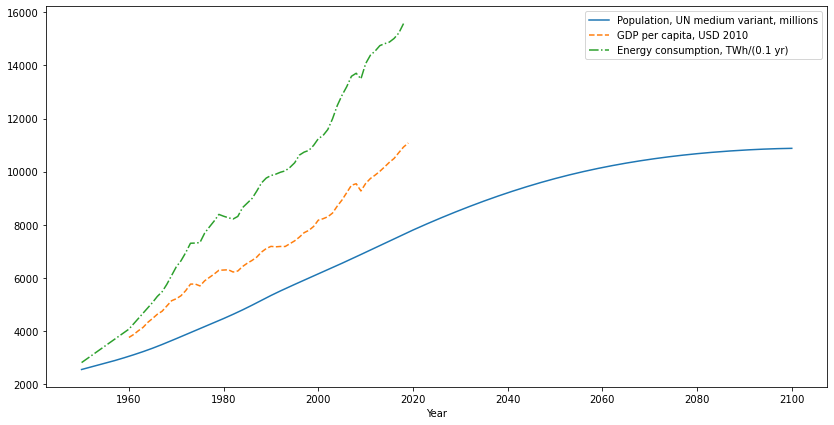

In [6]:
plt.figure(figsize=[14,7])
plt.plot(t, N, label='Population, UN medium variant, millions')
plt.plot(t, gdpPerCapita, linestyle='--', label='GDP per capita, USD 2010')
plt.plot(t, E/10, linestyle='-.', label='Energy consumption, TWh/(0.1 yr)')
plt.legend()
plt.xlabel('Year')
plt.show()

## Energy per capita

Energy is in units of TWh = 1,000,000 MWh. N is in units of 1,000,000 people. Therefore, energy per capita is in units of MWh.

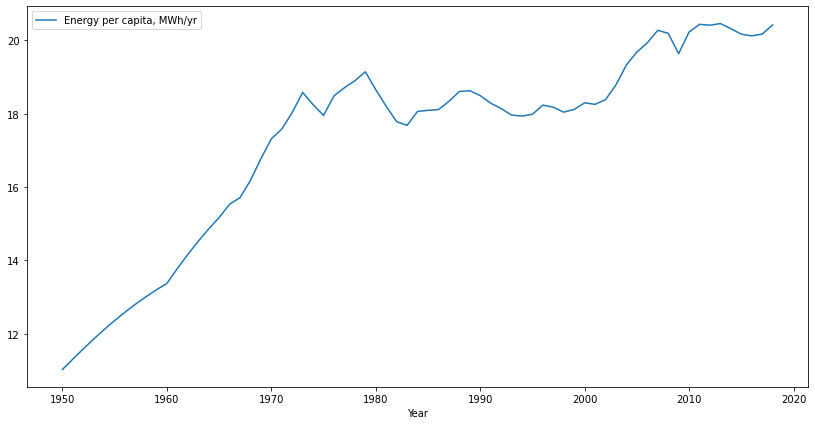

In [7]:
energyPerCapita = E / N

plt.figure(figsize=[14,7])
plt.plot(t,energyPerCapita,label='Energy per capita, MWh/yr')
plt.legend()
plt.xlabel('Year')
plt.show()

## Energy per USD of GDP

Energy per dollar is in units of MWh/USD, but we convert to kWh/USD by multiplying by 1000.


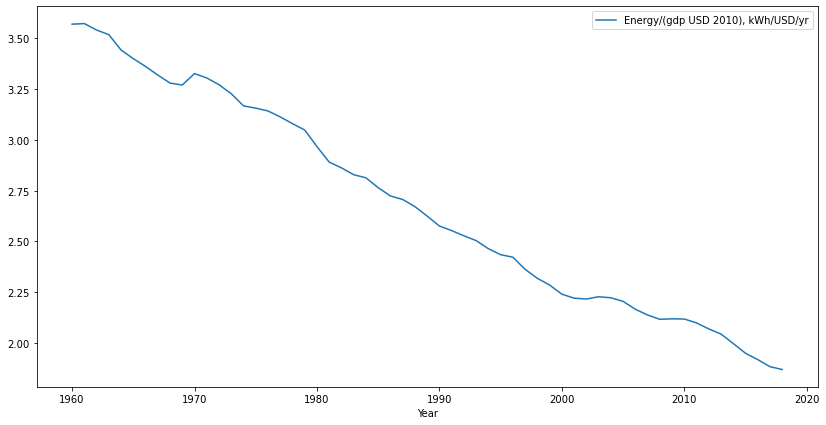

In [8]:
energyPerDollar = 1000 * E / (gdpPerCapita * N)

plt.figure(figsize=[14,7])
plt.plot(t,energyPerDollar,label='Energy/(gdp USD 2010), kWh/USD/yr')
plt.legend()
plt.xlabel('Year')
plt.show()

We are creating more value with less energy as time progresses.

## Save values of arrays

We can save our arrays for later in numpy binary format `np.save('array.npy',array)`, or as a text files `np.savetxt('array.txt',array)`, or as a collection of arrays in an archive using `np.savez()`. 

A file saved with `save('t.npy',t)` can be loaded in a new program with `t = np.load('t.npy')`.

In [9]:
np.save('t.npy', t)
np.save('N.npy', N)
np.save('E.npy', E)
np.save('gdpPerCapita.npy', gdpPerCapita)
np.save('energyPerCapita.npy', energyPerCapita)
np.save('energyPerDollar.npy', energyPerDollar)

---
**Further information**

United Nations, Department of Economic and Social Affairs, Population Division (2019). World Population Prospects 2019: Highlights (ST/ESA/SER.A/423).
https://www.un.org/development/desa/pd/  
https://population.un.org/wpp/Download/Standard/CSV/

World Bank economic data  
https://data.worldbank.org/indicator/NY.GDP.PCAP.KD

"Energy". Published online at OurWorldInData.org  
Hannah Ritchie and Max Roser. First published in 2015; most recent substantial revision in July 2018.  
https://ourworldindata.org/energy'   
The sources of the data used here are Vaclav Smil (2017; Energy Transitions: Global and National Perspectives) &  
BP Statistical Review of World Energy. 
